In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

In [ ]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

In [2]:
# Load the CIFAR-10 dataset and define transformations
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Create DataLoader for training
train_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13592932.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure values are in [0, 1]
    return noisy_image

# Create the autoencoder model and set up training
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        noisy_inputs = add_gaussian_noise(inputs)
        optimizer.zero_grad()
        outputs = autoencoder(noisy_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.0038
Epoch [2/10], Loss: 0.0037
Epoch [3/10], Loss: 0.0036
Epoch [4/10], Loss: 0.0034
Epoch [5/10], Loss: 0.0028
Epoch [6/10], Loss: 0.0025
Epoch [7/10], Loss: 0.0030
Epoch [8/10], Loss: 0.0026
Epoch [9/10], Loss: 0.0025
Epoch [10/10], Loss: 0.0027


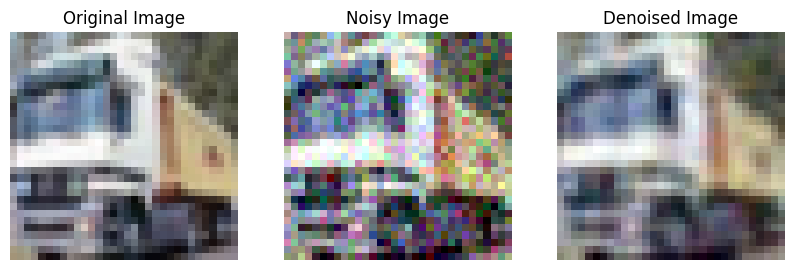

In [ ]:
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

def denoise_image(image):
    autoencoder.eval()
    with torch.no_grad():
        denoised_image = autoencoder(image.unsqueeze(0)).squeeze(0)
    return denoised_image


sample_index = 1  # Change this to select a different image
sample_image, _ = cifar_dataset[sample_index]
noisy_image = add_gaussian_noise(sample_image)

# Denoise the noisy image
denoised_image = denoise_image(noisy_image)

# Display the original, noisy, and denoised images
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(np.transpose(sample_image, (1, 2, 0)))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Noisy Image")
plt.imshow(np.transpose(noisy_image, (1, 2, 0)))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Denoised Image")
plt.imshow(np.transpose(denoised_image, (1, 2, 0)))
plt.axis('off')

plt.show()


In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#transform = transforms.Compose([transforms.ToTensor()])
#cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
image, _ = cifar_dataset[1]
image = image.numpy()

image = image.mean(axis=0)  # Convert to grayscale
image

array([[0.6771242 , 0.5215686 , 0.39738563, ..., 0.33594772, 0.32418302,
        0.3006536 ],
       [0.6130719 , 0.5908497 , 0.48104575, ..., 0.35686275, 0.28627452,
        0.26797387],
       [0.59999996, 0.5673203 , 0.44705883, ..., 0.29411766, 0.2522876 ,
        0.2496732 ],
       ...,
       [0.6640523 , 0.6143791 , 0.63267976, ..., 0.14640523, 0.22352941,
        0.34901962],
       [0.5843137 , 0.57254905, 0.6039216 , ..., 0.38169935, 0.46666667,
        0.5006536 ],
       [0.56339866, 0.55947715, 0.5908497 , ..., 0.5424837 , 0.5477125 ,
        0.54901963]], dtype=float32)

In [5]:
n_components = 2 # Adjust this value based on the desired compression level
pca = PCA(n_components=n_components)
image_pca = pca.fit_transform(image)

In [6]:
inverse_image = pca.inverse_transform(image_pca)

(-0.5, 31.5, 31.5, -0.5)

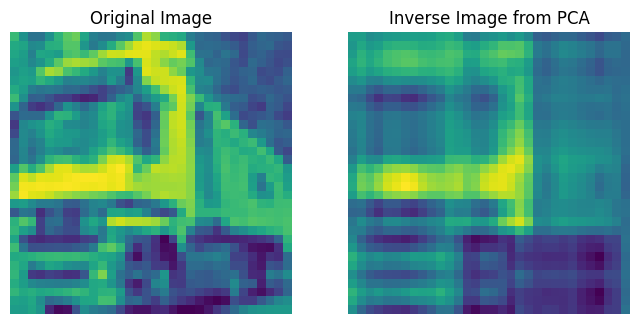

In [7]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Inverse Image from PCA")
plt.imshow(inverse_image)
plt.axis('off')

In [8]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1) ,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 4, 3, padding=1) ,
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)

        return x

# initialize the NN
model = ConvAutoencoder().to(device)

In [13]:
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# number of epochs to train the model
num_epochs = 20

for epoch in range(1, num_epochs):
  for images, _ in cifar_dataset:
        optimizer.zero_grad()
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
  print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.6003
Epoch [2/20], Loss: 0.6000
Epoch [3/20], Loss: 0.6007
Epoch [4/20], Loss: 0.5997
Epoch [5/20], Loss: 0.5989
Epoch [6/20], Loss: 0.5990
Epoch [7/20], Loss: 0.6000
Epoch [8/20], Loss: 0.5998
Epoch [9/20], Loss: 0.6005
Epoch [10/20], Loss: 0.6008
Epoch [11/20], Loss: 0.6008
Epoch [12/20], Loss: 0.6003
Epoch [13/20], Loss: 0.6004
Epoch [14/20], Loss: 0.6003
Epoch [15/20], Loss: 0.6005
Epoch [16/20], Loss: 0.6010
Epoch [17/20], Loss: 0.6008
Epoch [18/20], Loss: 0.6006
Epoch [19/20], Loss: 0.6012


(-0.5, 31.5, 31.5, -0.5)

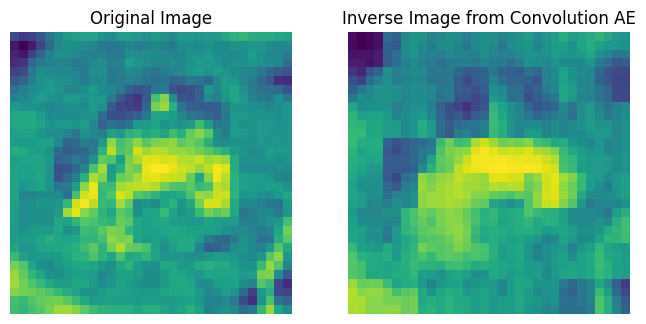

In [27]:
dataiter = iter(cifar_dataset)
images, labels = next(dataiter)

images = images.to(device)
output = model(images)

images = images.cpu().numpy()
output = output.view(3, 32, 32)
output = output.detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(images[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Inverse Image from Convolution AE")
plt.imshow(output[0])
plt.axis('off')